# Random Voting Games & Quantum Shapley Values
This notebook generates random voting games and uses a quantum algorithm to estimate the Shapley value of each player. 
It then performs some basic data analysis on the predictions.

### Import Libraries

In [4]:
import quantumBasicVotingGame as vg
from quantumShapEstimation import QuantumShapleyWrapper as qsw

import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

### Define Variables

In [5]:
numTrials = 50

minEll = 1
maxEll = 6

#Defining the different conditions
# numPlayersCond    = [4,8,12]
numPlayersCond    = [4,6,8,10]
thresholdBitCond  = [3,4,5,5]
roughVarianceCond = [1,1,2,2]


### Run Simulations

In [6]:
simulations = {}

for trialNum in tqdm(range(numTrials), desc="Current Trial"):
    for ell in tqdm(range(minEll,maxEll+1), desc="Current Ell"):
        for n, thresholdBits, roughVariance in zip(
            numPlayersCond, thresholdBitCond, roughVarianceCond
        ):
            trial = (n,ell,trialNum)


            #New random game
            threshold = 2**(thresholdBits-1)
            playerVals = vg.randomVotingGame(
                numPlayers=n,
                thresholdBits=thresholdBits,
                roughVariance=roughVariance
            )

            #quantum Shapley
            qshaps = vg.quantumVotingShap(
                threshold=threshold,
                playerVals=playerVals,
                ell=ell
            )

            #classical Shapley
            cshaps = vg.classicalVotingShap(
                threshold=threshold,
                playerVals=playerVals,
            )

            #Store outcome
            simulations[trial] = (qshaps, cshaps)



Current Trial:   0%|          | 0/50 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

Current Ell:   0%|          | 0/6 [00:00<?, ?it/s]

### Save Results

In [7]:
with open('shapleyVoteResults.pkl', 'wb') as f:
    pickle.dump(simulations, f)

In [8]:
# with open('shapleyVoteResults_Apr30_11-55PM.pkl', 'rb') as fp:
#     simulations = pickle.load(fp)

### Analyze Trials 

In [9]:
def meanAbsError(qshaps, cshaps):
    err = 0
    for qshap, cshap in zip(qshaps, cshaps):
        err += abs(qshap-cshap)
    return err

n=4: [5.99793808e-02 1.30051702e-02 2.19197720e-03 3.44589000e-04
 8.89432000e-05]
n=4: [0.0, 1.5399999999665681e-06, 0.0, 0.0, 0.0]
n=6: [0.16319448 0.02002237 0.00500835 0.00120386 0.00021799]
n=6: [4.440892098500626e-16, 4.440892098500626e-16, 5.9480000000111666e-05, 0.00017628000000002864, 4.440892098500626e-16]
n=8: [0.25853305 0.02430151 0.00608229 0.00168357 0.00060876]
n=8: [0.0002428400000004105, 1.5543122344752192e-15, 0.0002495799999994164, 0.0003146600000000707, 6.00800000000179e-05]
n=10: [0.28601567 0.03026643 0.00526746 0.00082446 0.00035872]
n=10: [0.00047275999999829565, 0.004022053333334358, 5.990000000166695e-05, 3.0200000002283955e-05, 6.005000000069982e-05]


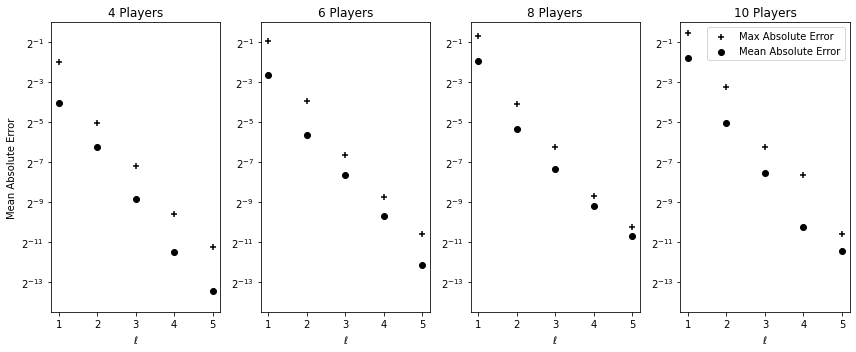

In [68]:
# print(simulations)
plt.rcParams['figure.figsize'] = [12, 5]
fig, ax = plt.subplots(1, len(numPlayersCond))
ax[0].set_ylabel(r"Mean Absolute Error")

#We're looking to find reciprocal mean abs error per trial
#For each trial with n players
for i, n in enumerate(numPlayersCond):
    #Orient data
    resultsX = []
    resultsY = []
    resultMax = []
    resultMin = []
    resultErr = []
    for ell in range(minEll, maxEll):
        trialOutcomes = []

        for trialNum in range(numTrials):
            qshaps, cshaps = simulations[(n,ell,trialNum)]
            # trialOutcomes.append(
            #     meanAbsError(qshaps, cshaps)
            # )
            diffs = np.array(qshaps) - np.array(cshaps)
            # print(diffs)
            trialOutcomes.append(np.linalg.norm(diffs, ord=1))
        
        trialOutcomes = np.array(trialOutcomes)
        resultsX.append(ell)
        resultsY.append(trialOutcomes.mean())
        resultErr.append(trialOutcomes.std())
        resultMax.append(trialOutcomes.max())
        resultMin.append(trialOutcomes.min())

        # resultsX += len(trialOutcomes) * [ell]
        # resultsY += trialOutcomes
    
    ax[i].set_title(f"{n} Players")#, Threshold: {2**thresholdBitCond[i]}")
    ax[i].scatter(
        np.array(resultsX),
        np.array(resultMax),
        # fmt='+',
        # yerr=resultErr,
        # align='center',
        # alpha=0.5,
        color='black',
        # capsize=5,
        marker='+',
        label='Max Absolute Error'
    )
    ax[i].scatter(
        np.array(resultsX),
        np.array(resultsY),
        # yerr = np.array(resultMax)-np.array(resultMin),#np.array(resultErr),#temp
        # fmt='o',
        # yerr=resultErr,
        # align='center',
        # alpha=0.5,
        color='black',
        # capsize=5,
        label='Mean Absolute Error'
    )
    ax[i].set_xlabel(r"$\ell$")
    ax[i].set_yscale('log',base=2)
    ax[i].set_ylim(2**(-14.5),1)
    # if i!=0: ax[i].tick_params(left=False,labelleft=False)
    print(f"{n=}:", np.array(resultsY))
    print(f"{n=}:",resultMin)

ax[-1].legend()
plt.tight_layout()
plt.show()